In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import plot_model

In [2]:
from nltk.tokenize import word_tokenize

In [3]:
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
except:
    pass

Carrega tokenizador para português do NLTK

In [4]:
tokenizer = lambda x: word_tokenize(x, language='portuguese')

Carrega dados da b2W

In [5]:
data = pd.read_csv('../data/B2W-Reviews01.csv', sep=';')[['review_title', 'review_text']]

/home/pi/anaconda3/envs/tf2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
X, y = data.review_text.values, data.review_title.values

Faz divisão de treino e teste

In [7]:
VOCAB_SIZE = 30_000

In [10]:
data_path = '../prepared_data/lstm/'

In [11]:
tr_reviews = open(data_path + 'tr_reviews.txt', encoding='utf-8').readlines()
tr_titles = open(data_path + 'tr_titles.txt', encoding='utf-8').readlines()
te_reviews = open(data_path + 'te_reviews.txt', encoding='utf-8').readlines()
te_titles = open(data_path + 'te_titles.txt', encoding='utf-8').readlines()

In [12]:
tr_reviews, tr_titles, te_reviews, te_titles = [[ ['<s>'] + tokenizer(text) + ['</s>'] for text in dataset]
                                                    for dataset in (tr_reviews, tr_titles, te_reviews, te_titles)]

In [13]:
text2idx = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<unk>', 
                                              lower=False)
text2idx.fit_on_texts(tr_reviews)

In [14]:
tr_reviews_idx, tr_titles_idx, te_reviews_idx, te_titles_idx = [
        text2idx.texts_to_sequences(s) for s in [tr_reviews, tr_titles, te_reviews, te_titles]
]

In [16]:

# Faz padding
pad_x = lambda x: pad_sequences(x, maxlen=58, padding='pre')
pad_y = lambda y: pad_sequences(y, maxlen=11, padding='post')

tr_reviews_idx, te_reviews_idx = pad_x(tr_reviews_idx), pad_x(te_reviews_idx)
tr_titles_idx, te_titles_idx = pad_y(tr_titles_idx), pad_y(te_titles_idx)


In [17]:
import sys

In [18]:
sys.path.append('../')

In [19]:
from src.lstm_model import build_model

In [20]:
model = build_model(58, 11, VOCAB_SIZE, 128)

In [23]:
optim = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optim, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [25]:
# Cria variável target (próxima palavra da sequência)
tr_titles_idx_next = np.array([
    array[1:].tolist() + [0] for array in tr_titles_idx
])

# Usa os primeiros 10% dos dados para validação
val_break = int(len(tr_reviews_idx)*0.1)
val_data = ([tr_reviews_idx[:val_break], tr_titles_idx[:val_break]], tr_titles_idx_next[:val_break])


In [26]:
# Faz ajuste do modelo
loss_hist = model.fit(x=[tr_reviews_idx[val_break:], tr_titles_idx[val_break:]],
                      y=tr_titles_idx_next[val_break:],
                      batch_size=512, epochs=30,
                      callbacks=callbacks, validation_data=val_data)


Epoch 1/30
187/187 [==============================] - 48s 258ms/step - loss: 2.7038 - val_loss: 1.7983
Epoch 2/30
187/187 [==============================] - 47s 253ms/step - loss: 1.7210 - val_loss: 1.6751
Epoch 3/30
187/187 [==============================] - 47s 251ms/step - loss: 1.5827 - val_loss: 1.5395
Epoch 4/30
187/187 [==============================] - 47s 252ms/step - loss: 1.4454 - val_loss: 1.4550
Epoch 5/30
187/187 [==============================] - 47s 251ms/step - loss: 1.3619 - val_loss: 1.4137
Epoch 6/30
187/187 [==============================] - 47s 251ms/step - loss: 1.3037 - val_loss: 1.3857
Epoch 7/30
187/187 [==============================] - 47s 250ms/step - loss: 1.2554 - val_loss: 1.3692
Epoch 8/30
187/187 [==============================] - 47s 252ms/step - loss: 1.2141 - val_loss: 1.3570
Epoch 9/30
187/187 [==============================] - 47s 250ms/step - loss: 1.1748 - val_loss: 1.3524
Epoch 10/30
187/187 [==============================] - 47s 252ms/step - l

In [32]:
val_X_idx = val_data[0][0]
val_y_idx = val_data[0][1]

In [29]:
def write_title(review_text_idx, return_also_idx=False):
    global model, text2idx
    
    start = ['<s>']
    start_idx = [text2idx.word_index['<s>']]
    
    for i in range(11):
        out = model.predict([
            np.array([review_text_idx]), pad_y(text2idx.texts_to_sequences([start]))
        ])
        
        next_token = text2idx.sequences_to_texts(
            [[out.argmax(axis=-1)[0][i]]]
        )[0]
        
        start.append(next_token)
        start_idx.append([out.argmax(axis=-1)[0][i]][0])
        
        if next_token == '</s>':
            break
    
    if return_also_idx:
        return start, np.array(start_idx)
    
    return start

In [46]:
plt.style.use('ggplot')

In [185]:
def plot_attention_map(review_text_idx, predicted_title_idx):
    emb_layer, encoder, decoder = model.layers[2], model.layers[3], model.layers[4]
    
    global text2idx
    
    # Aplica modelo e salva output da camada de atenção
    if len(review_text_idx.shape) < 2:
        x, y = review_text_idx[None, ...], predicted_title_idx[None, ...]
    
    x, y = emb_layer(x), emb_layer(y)
    
    encoded_review_h, encoded_review_last_state = encoder(x)
    decoded_title, attention_map = decoder(y, encoded_review_h, encoded_review_last_state)
    
    # Calcula mapa de atenção
    attention_map = attention_map.numpy().squeeze()
    
    # Remove tokens de padding
    x_text_mask = (review_text_idx != 0)
    y_text_mask = (predicted_title_idx != 0)
    
    # Cria gráfico
    # Obs: para facilitar a visualização o eixo e x e y são trocados, isto é, a variável x será
    # plotada no eixo y e a variável y no eixo x.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))

    img = ax.imshow(attention_map[x_text_mask][:, y_text_mask], aspect='auto')
    
    y_label_list = text2idx.sequences_to_texts([review_text_idx[x_text_mask]])[0].split(' ')
    x_label_list = text2idx.sequences_to_texts([predicted_title_idx[y_text_mask]])[0].split(' ')
    
    
    x_label_list[0] = '[bos]'
    x_label_list[-1] = '[eos]'
        
    x_label_list = ['[unk]' if l == '<unk>' else l for l in x_label_list]
    y_label_list = ['[unk]' if l == '<unk>' else l for l in y_label_list]
        
    y_label_list[0] = '[bos]'
    y_label_list[-1] = '[eos]'
    
    ax.set_xticks(np.arange(len(x_label_list)))
    ax.set_yticks(np.arange(len(y_label_list)))

    ax.set_xticklabels(x_label_list, fontsize='large')
    ax.set_yticklabels(y_label_list, fontsize='large')

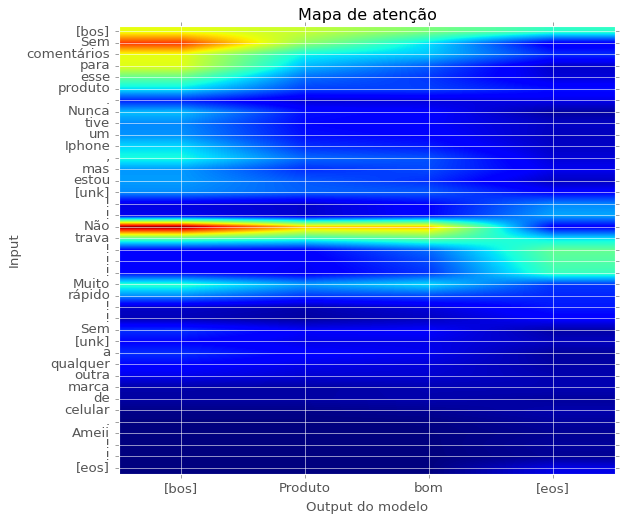

In [186]:
index = -2000
predicted_title, predicted_title_idx = write_title(val_X_idx[index], return_also_idx=True)
plot_attention_map(val_X_idx[index], predicted_title_idx)
plt.xlabel('Output do modelo')
plt.ylabel('Input')
plt.title('Mapa de atenção')
plt.savefig('../report/fig2.pgf')

## Modelo

Encoder

In [32]:
class Encoder(keras.Model):
    def __init__(self, lstm_hidden=50):
        super(Encoder, self).__init__()
        self.lstm = keras.layers.Bidirectional(
            keras.layers.LSTM(lstm_hidden, return_sequences=True, return_state=True)
        )

    def call(self, tokenized_text):
        # Converte tokens em embeddings
        # tokenized_text = self.embedding_layer(tokenized_text)
        
        # Passa os embeddings p/ uma camada LSTM 
        seq_hidden_states, left_h, left_c, right_h, right_c = self.lstm(tokenized_text)
        
        last_h = tf.concat([left_h, right_h], axis=1)
        last_c = tf.concat([left_c, right_c], axis=1)
        
        # Retorna a sequência de unidades ocultas e o último estado da lstm        
        return seq_hidden_states, [last_h, last_c]

In [33]:
class TeacherForcedDecoder(keras.Model):
    def __init__(self, vocab_size, lstm_hidden=100):
        super(TeacherForcedDecoder, self).__init__()
                
        # LSTM pós camada de embeddings
        self.lstm = keras.layers.LSTM(lstm_hidden, return_sequences=True)
        
        # LSTM pós camada de atenção
        self.context_augmented_lstm = keras.layers.LSTM(lstm_hidden, return_sequences=True)

        # Camada de dropout
        self.drop = keras.layers.Dropout(0.5)
        
        # Camada final de saída do decoder
        self.fc1 = keras.layers.Dense(300, activation='selu')
        self.output_layer = keras.layers.Dense(vocab_size)

    def calc_attention(self, encoder_hidden, decoder_hidden):
        '''
            Inputs:
                encoder_hidden (batch_size, encoder_length, hidden)
                decoder_hidden (batch_size, decoder_length, hidden)
            Output:
                (
                    context_vector
                )
        '''
        # Obtem attention_score (batch_size, encoder_length, decoder_length)
        attention_scores = tf.matmul(encoder_hidden, decoder_hidden, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=1)
        
        # Calcula o vetor de contextos como uma média ponderada de `encoder_hidden` 
        # segundo os escores de atenção.
        context_vectors = tf.matmul(attention_scores, encoder_hidden, transpose_a=True)
        
        # Retorna
        #   - Os vetores de contexto (batch_size, decoder_length, hidden)
        #   - Os escores de atenção (batch_size, encoder_length, decoder_length)
        return context_vectors, attention_scores
        
    def call(self, ouput_emb, encoder_h, encoder_end_state, training=False):
        '''
            Recebe a sequência de saída completa, por exemplo:
                [<s>, Produto, muito, bom, </s>, <pad>, <pad>]
            
            E prevê com o próximo token da sequência de saída, por exemplo:
                [Produto, muito, bom, </s>, <pad>, <pad>, <pad>]
            
            Note que são passados sempre os tokens corretos da sequência como entrada, isto é, se o decodificador
            prever que o próximo token da sequência '<s> Produto' é o token 'ruim', isso será considerado 
            como um erro (sendo assim penalizado na função de perda), mas para t+1 será fornecido o token 'muito'.
            
            Essa metodologia de aprendizado é conhecida como 'teacher forcing', pois forçamos no modelo
            a sequência correta de tokens. Isso é útil pois acelera a convergência de modelos seq2seq e 
            simplifica a implementação do modelo.
            
            Numa situação real de inferência, basta fornecer o token <s> como `output_text` para
            obter uma previsão para o próximo token. Depois, basta retroalimentar a rede
            com o novo token output. Este procedimento deve ser repetido até se obter o token de fim
            de sentença </s>. 
        '''
        # Obtém embeddings da sequência de saída
        # ouput_emb = self.embedding_layer(output_text)
        
        # Obtém os hidden states da sequência de saída (batch_size, decoder_length, hidden)
        # é importante que esta LSTM utilize o último estado da LSTM do Encoder.
        output_h = self.lstm(ouput_emb, initial_state=encoder_end_state)
        
        # Obtém o vetor contexto (batch_size, decoder_length, hidden) a partir dos
        # pesos de atenção
        context_vector, att_weights = self.calc_attention(encoder_h, output_h)
        
        # Concatena o vetor de contextos aos hidden states `output_h`,
        # produzindo o tensor (batch_size, decoder_length, 2*hidden)
        output_h = tf.concat([output_h, context_vector], axis=-1)
        
        # Passa o resultado para uma lstm final
        # Não é obrigatório, mas vamos usar os estados finais da LSTM do encoder também
        final_h = self.context_augmented_lstm(output_h, initial_state=encoder_end_state)
        
        # Aplica dropout em final_h
        if training:
            final_h = self.drop(final_h)
        
        # Transforma o resultado em um tensor (batch_size, decoder_length, vocab_size)
        #output = self.output_layer(final_h)
        output_h = self.fc1(output_h)
        output = self.output_layer(output_h)
        
        # Retorna o output do modelo e os pesos de atenção (para análise)
        return output, att_weights

## Modelo

In [34]:
def get_model(max_len_X, max_len_y, vocab_size, emb_dim):
    # Define inputs
    input_review = keras.Input(shape=max_len_X, dtype="int32")
    input_review_title = keras.Input(shape=max_len_y, dtype="int32")
    
    # Cria encoder e decoder
    encoder = Encoder()
    decoder = TeacherForcedDecoder(vocab_size+1)
    
    # Cria camada de embedding e de masking
    emb_layer = keras.layers.Embedding(vocab_size+1, 128)
    mask_layer = keras.layers.Masking(mask_value=0)
    
    # Aplica mascara nos reviews e converte review e titulo em embeddings
    masked_review_title = mask_layer(input_review_title)
    x = emb_layer(input_review)
    y = emb_layer(input_review_title)
    
    # Aplica encoder e decoder
    encoded_review_h, encoded_review_last_state = encoder(x)
    decoded_title, _ = decoder(y, encoded_review_h, encoded_review_last_state)
    
    # Retorna keras.Model
    return keras.Model(inputs=[input_review, input_review_title], outputs=decoded_title)

Cria modelo

In [35]:
model = get_model(max_len_X, max_len_y, VOCAB_SIZE, 128)

Compila modelo

In [36]:
optim = keras.optimizers.Adam(learning_rate=1e-3)

In [37]:
model.compile(optimizer=optim, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

--------

Cria sequência de respostas (próximo token do título)

In [38]:
tr_y_idx_next = np.array([
    array[1:].tolist() + [0] for array in tr_y_idx
])

Define callbacks de treinamento

In [39]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

Treina modelo. Usa os primeiros 10% da base para validação

In [40]:
val_break = int(len(tr_X_idx)*0.1)
val_data = ([tr_X_idx[:val_break], tr_y_idx[:val_break]], tr_y_idx_next[:val_break])

In [41]:
model.fit(x=[tr_X_idx[val_break:], tr_y_idx[val_break:]], y=tr_y_idx_next[val_break:],
          batch_size=512, epochs=70, callbacks=callbacks, validation_data=val_data)

Epoch 1/70
187/187 [==============================] - 21s 112ms/step - loss: 2.3860 - val_loss: 1.6537
Epoch 2/70
187/187 [==============================] - 20s 107ms/step - loss: 1.5785 - val_loss: 1.5197
Epoch 3/70
187/187 [==============================] - 20s 107ms/step - loss: 1.4325 - val_loss: 1.3799
Epoch 4/70
187/187 [==============================] - 20s 107ms/step - loss: 1.3210 - val_loss: 1.3165
Epoch 5/70
187/187 [==============================] - 20s 107ms/step - loss: 1.2597 - val_loss: 1.2784
Epoch 6/70
187/187 [==============================] - 20s 108ms/step - loss: 1.2153 - val_loss: 1.2560
Epoch 7/70
187/187 [==============================] - 20s 108ms/step - loss: 1.1787 - val_loss: 1.2334
Epoch 8/70
187/187 [==============================] - 21s 110ms/step - loss: 1.1472 - val_loss: 1.2205
Epoch 9/70
187/187 [==============================] - 21s 111ms/step - loss: 1.1177 - val_loss: 1.2094
Epoch 10/70
187/187 [==============================] - 21s 110ms/step - l

In [ ]:
index = -956
predicted_title, predicted_title_idx = write_title(te_X_idx[index], return_also_idx=True)
plot_attention_map(te_X_idx[index], predicted_title_idx)
plt.xlabel('Output do modelo')
plt.ylabel('Input')
plt.title('Mapa de atenção')
plt.savefig('./fig1.pgf')

In [1121]:
#model.save_weights('./lstm_weights/')

## Testa modelo

In [29]:
review_texts_idx = tr_X_idx[0:2]

In [30]:
start = [['<s>'] for _ in range(len(review_texts_idx))]
start_idx = [[text2idx.word_index['<s>']] for _ in range(len(review_texts_idx))]

In [36]:
model.predict([
    np.array(review_texts_idx), pad_y(text2idx.texts_to_sequences(start))
]).argmax(axis=-1)

array([[11,  5,  5,  0,  0,  0,  0,  0,  0,  0,  0],
       [11,  5,  5,  0,  0,  0,  0,  0,  0,  0,  0]])

In [42]:
i=0

array([5, 5])

In [55]:
next_token = model.predict([
            np.array(review_texts_idx), pad_y(text2idx.texts_to_sequences(start))
        ]).argmax(axis=-1)[:, i, True]

In [56]:
next_token

array([[11],
       [11]])

In [57]:
text2idx.sequences_to_texts(next_token)

['produto', 'produto']

In [59]:
start_idx

[[4], [4]]

In [62]:
[1] + next_token[0].tolist()

[1, 11]

In [76]:
def write_titles(model, text2idx, review_texts_idx, return_also_idx=False, max_title_len=11):
    ''' Versão mais eficiente para escrever múltiplos títulos de uma vez só'''
    start = [['<s>'] for _ in range(len(review_texts_idx))]
    start_idx = [[text2idx.word_index['<s>']] for _ in range(len(review_texts_idx))]
    
    for i in range(max_title_len):
        next_tokens_idx = model.predict([
            np.array(review_texts_idx), pad_y(text2idx.texts_to_sequences(start))
        ]).argmax(axis=-1)[:, i, True]
        
        next_tokens = text2idx.sequences_to_texts(next_tokens_idx)
        
        for text_nb, next_token in enumerate(next_tokens):
            start[text_nb] += [next_token]
            start_idx[text_nb] += next_tokens_idx[text_nb].tolist()

    # Remove tudo após o token </s>
    start = [
        start_i[0:start_i.index('</s>')+1] if '</s>' in start_i else start_i
        for start_i in start
    ]
    
    start_idx = [
        start_idx[i][0:len(start[i])+1] for i in range(len(start))
    ]
    
    if return_also_idx:
        return start, np.array(start_idx)
    
    return start

In [78]:
write_titles(model, text2idx, tr_X_idx[0:5])

[['<s>', 'produto', 'muito', 'bom', '</s>'],
 ['<s>', 'produto', 'excelente', '</s>'],
 ['<s>', 'gostei', 'muito', 'do', 'produto', '</s>'],
 ['<s>', 'gostei', 'muito', 'do', 'produto', '</s>'],
 ['<s>', 'não', 'recebi', 'o', 'produto', '</s>']]

In [1490]:
def write_title(review_text_idx, return_also_idx=False):
    global model, text2idx
    
    start = ['<s>']
    start_idx = [text2idx.word_index['<s>']]
    
    for i in range(11):
        out = model.predict([
            np.array([review_text_idx]), pad_y(text2idx.texts_to_sequences([start]))
        ])
        
        next_token = text2idx.sequences_to_texts(
            [[out.argmax(axis=-1)[0][i]]]
        )[0]
        
        start.append(next_token)
        start_idx.append([out.argmax(axis=-1)[0][i]][0])
        
        if next_token == '</s>':
            break
    
    if return_also_idx:
        return start, np.array(start_idx)
    
    return start

## Inspeciona resultados

In [1491]:
def plot_attention_map(review_text_idx, predicted_title_idx):
    global text2idx, emb_layer, encoder, decoder
    
    # Aplica modelo e salva output da camada de atenção
    if len(review_text_idx.shape) < 2:
        x, y = review_text_idx[None, ...], predicted_title_idx[None, ...]
    
    x, y = emb_layer(x), emb_layer(y)
    
    encoded_review_h, encoded_review_last_state = encoder(x)
    decoded_title, attention_map = decoder(y, encoded_review_h, encoded_review_last_state)
    
    # Calcula mapa de atenção
    attention_map = attention_map.numpy().squeeze()
    
    # Remove tokens de padding
    x_text_mask = (review_text_idx != 0)
    y_text_mask = (predicted_title_idx != 0)
    
    # Cria gráfico
    # Obs: para facilitar a visualização o eixo e x e y são trocados, isto é, a variável x será
    # plotada no eixo y e a variável y no eixo x.
    fig, ax = plt.subplots(1,1, figsize=(10, 7))

    img = ax.imshow(attention_map[x_text_mask][:, y_text_mask], aspect='auto')
    
    y_label_list = text2idx.sequences_to_texts([review_text_idx[x_text_mask]])[0].split(' ')
    x_label_list = text2idx.sequences_to_texts([predicted_title_idx[y_text_mask]])[0].split(' ')
    
    ax.set_xticks(np.arange(len(x_label_list)))
    ax.set_yticks(np.arange(len(y_label_list)))

    ax.set_xticklabels(x_label_list)
    ax.set_yticklabels(y_label_list)

In [1492]:
plt.style.use('ggplot')

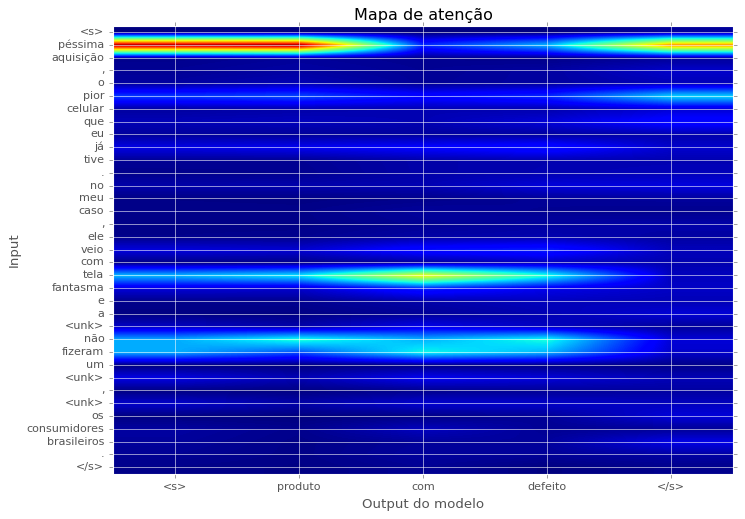

In [1493]:
index = -956
predicted_title, predicted_title_idx = write_title(te_X_idx[index], return_also_idx=True)
plot_attention_map(te_X_idx[index], predicted_title_idx)
plt.xlabel('Output do modelo')
plt.ylabel('Input')
plt.title('Mapa de atenção')
plt.savefig('./fig1.pgf')

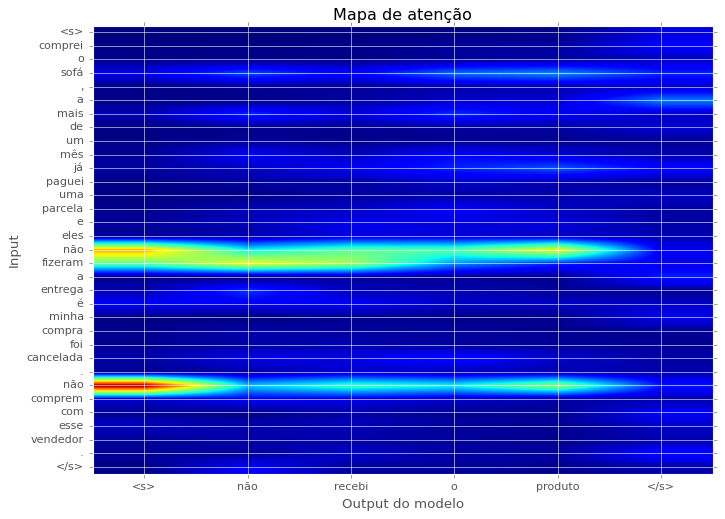

In [1441]:
index = -12
predicted_title, predicted_title_idx = write_title(te_X_idx[index], return_also_idx=True)
plot_attention_map(te_X_idx[index], predicted_title_idx)
plt.xlabel('Output do modelo')
plt.ylabel('Input')
plt.title('Mapa de atenção')
plt.savefig('./fig2.pgf')

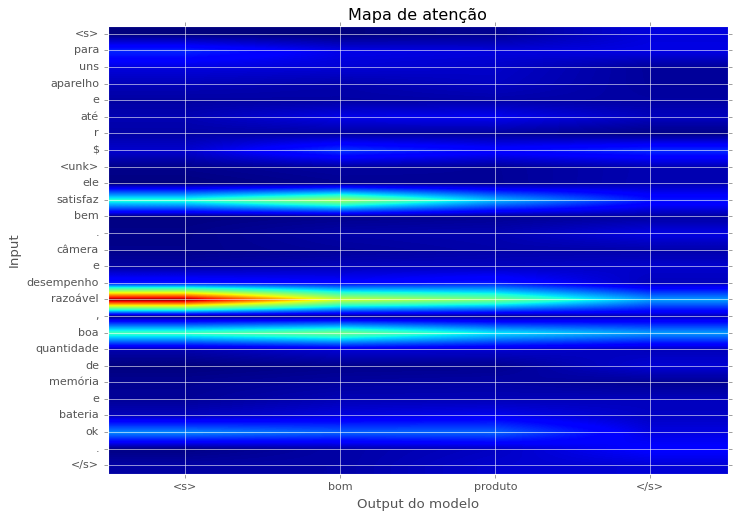

In [1442]:
index = 51
predicted_title, predicted_title_idx = write_title(te_X_idx[index], return_also_idx=True)
plot_attention_map(te_X_idx[index], predicted_title_idx)
plt.xlabel('Output do modelo')
plt.ylabel('Input')
plt.title('Mapa de atenção')
plt.savefig('./fig3.pgf')

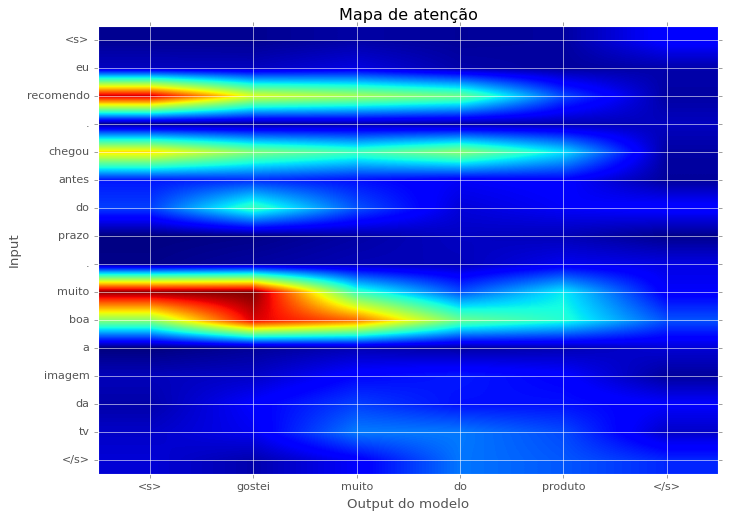

In [1443]:
index = 7
predicted_title, predicted_title_idx = write_title(te_X_idx[index], return_also_idx=True)
plot_attention_map(te_X_idx[index], predicted_title_idx)
plt.xlabel('Output do modelo')
plt.ylabel('Input')
plt.title('Mapa de atenção')
plt.savefig('./fig4.pgf')